In [1]:
import torch
torch.__version__

'1.11.0'

In [2]:
import mmcv
mmcv.__version__

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


'1.7.1'

In [3]:
import mmseg
mmseg.__version__

'0.30.0'

In [4]:
!wget https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar/resolve/main/burn_scars_Prithvi_100M.pth -P ./pretrain/

--2023-08-14 21:35:22--  https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar/resolve/main/burn_scars_Prithvi_100M.pth
huggingface.co (huggingface.co) をDNSに問いあわせています... 2600:9000:26a7:c200:17:b174:6d00:93a1, 2600:9000:26a7:8400:17:b174:6d00:93a1, 2600:9000:26a7:e200:17:b174:6d00:93a1, ...
huggingface.co (huggingface.co)|2600:9000:26a7:c200:17:b174:6d00:93a1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://cdn-lfs.huggingface.co/repos/fe/de/fedeb9f5774b7cdd6bf2554e426d2b8e2807dcfae6588e67971eb0229d4da10e/9285c40cc6005c1bafb40c3d245aafd445f37ba2d89b6ec5af7b21316e0fc284?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27burn_scars_Prithvi_100M.pth%3B+filename%3D%22burn_scars_Prithvi_100M.pth%22%3B&Expires=1692275722&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MjI3NTcyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mZS9kZS9mZWRlYjlmNTc3NGI3Y2RkNmJmMjU1NGU0MjZkMmI

In [6]:
%cd hls-foundation-os

/workspace/src/hls-foundation-os


## Burn

https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar

In [7]:
import os
os.makedirs('output/burn/', exist_ok=True)
os.makedirs('input/burn/', exist_ok=True)

In [8]:
import tifffile
import cv2
import numpy as np

img = tifffile.imread('../../sample/ROIs1158_spring_s2/s2_1/ROIs1158_spring_s2_1_p30.tif')
print(img.shape, img.dtype)

# 13 --> 6
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
img_band = np.stack([
    img[:, :, 1], img[:, :, 2], img[:, :, 3], # RGB
    img[:, :, 8], img[:, :, 11], img[:, :, 12],
    ], 
    axis=0) 

print(img_band.shape, img_band.dtype)
# img_ts = np.stack([img_band]*3, axis=0)
# print(img_ts.shape, img_ts.dtype)

# save as tif
tifffile.imwrite('input/burn/ROIs1158_spring_s2_1_p30_burn.tif', img_band)

(256, 256, 13) uint16
(6, 256, 256) uint16


## Config 修正
```python
channel_last=False
``` 
に変更する

In [9]:
!python model_inference.py -config configs/burn_scars.py \
    -ckpt ../pretrain/burn_scars_Prithvi_100M.pth \
    -input input/burn/ \
    -output output/burn/ -input_type tif -bands "[0,1,2,3,4,5]"

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/workspace/src/mmsegmentation/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
load checkpoint from local path: ../pretrain/burn_scars_Prithvi_100M.pth
Identified images to predict on: 1
Working on Image 0
Running inference...
Output has shape: (256, 256)
/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGe

(256, 256)


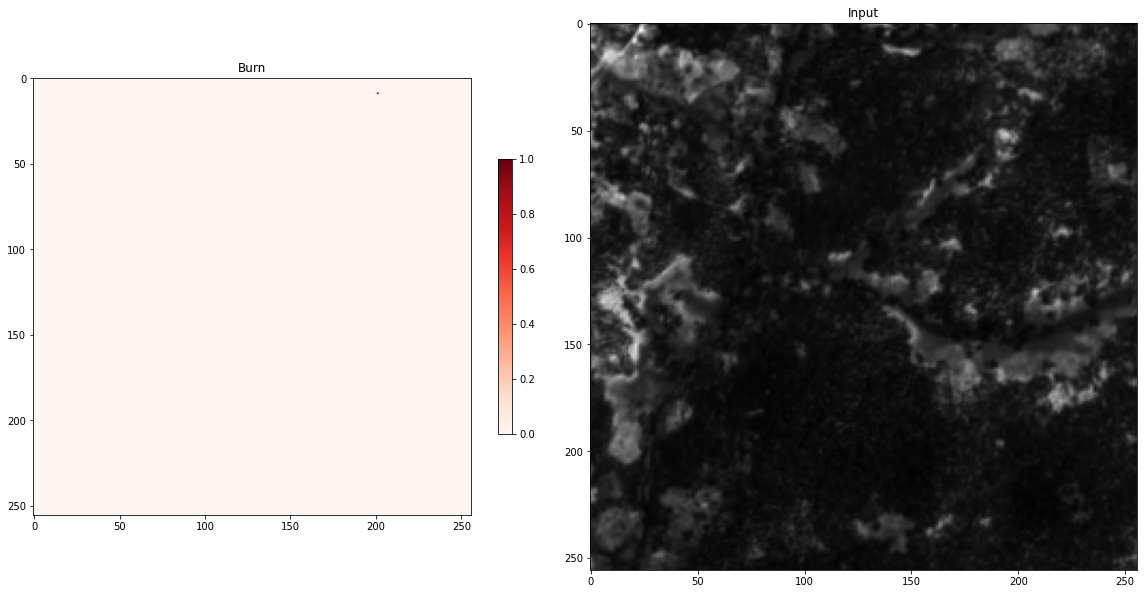

In [10]:
PATH_OUT = f'output/burn/ROIs1158_spring_s2_1_p30_burn_pred.tif'

import matplotlib.pyplot as plt
pred_t0 = tifffile.imread(PATH_OUT)
print(pred_t0.shape)

# plot image
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Burn')
plt.imshow(pred_t0, cmap='Reds', vmin=0, vmax=1)
plt.colorbar(shrink=0.5)

plt.subplot(1, 2, 2)
plt.title('Input')
plt.imshow(img_band[2], cmap='gray')

# off grid
plt.tight_layout()
plt.grid(False)